### Importing all required files

In [1]:
%matplotlib inline
from collections import defaultdict
import numpy as np
import torch
from torch.autograd import Variable
from torchvision.utils import save_image
from matplotlib import pyplot as plt

from networks import DualGansGenerator, CycleGanResnetGenerator, GeneratorUNet
from data_loader import DataLoader

### Specifying the settings for demo

In [2]:
data_root = "./gta/images/"
model_names = ['dual_gans_un', 'dual_gans_semi', 'cycle_gan_un', 'cycle_gan_semi', 'semantic']
model_dict = defaultdict.fromkeys(model_names)
model_dict_recon = defaultdict.fromkeys(model_names)
image_size = 256
ngpu = torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Setting file names for all models

In [3]:
for i in range(len(model_names)):
    path = 'saved_models/test_' + model_names[i] + '_generator_b.pth'
    model_dict[model_names[i]] = path
    
for i in range(len(model_names) - 1):
    path = 'saved_models/test_' + model_names[i] + '_generator_a.pth'
    model_dict_recon[model_names[i]] = path

In [4]:
def normalize(image):
    return (image - torch.min(image))/(torch.max(image) - torch.min(image))

def process_image(ax, img_title, image):
    ax.set_title(img_title)
    ax.imshow(image)
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_major_locator(plt.NullLocator())
    
def display_test_image(model_name, gta, cityscapes, gta_recon, semantic_sample):
    j = 1
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
    f.suptitle(model_name, fontsize=18)
    process_image(ax1, 'Original GTA Image', np.moveaxis(gta[j,:,:,:].data.detach().cpu().numpy(), 0, -1))
    process_image(ax2, 'Adapted Cityscapes Image', np.moveaxis(cityscapes[j,:,:,:].data.detach().cpu().numpy(), 0, -1))
    process_image(ax3, 'Reconstructed GTA Image', np.moveaxis(gta_recon[j,:,:,:].data.detach().cpu().numpy(), 0, -1))
    process_image(ax4, 'Segmented Adapted Cityscapes Image', np.moveaxis(semantic_sample[j,:,:,:].data.detach().cpu().numpy(), 0, -1),)
    plt.show()

def load_model(generator, model_state_file):
    model = generator.to(device)
    model.load_state_dict(torch.load(model_state_file))
    return model

def generate_test_image(generator, reconstructor, semantic_model, gta_image):
    cityscapes = normalize(generator(gta_image))
    gta  = normalize(reconstructor(cityscapes))
    semantic = normalize(semantic_model(cityscapes))
    return cityscapes, gta, semantic

def save_test_image(file_name, gta, cityscapes, gta_recon, semantic_sample):
    test_out = torch.cat((gta[1,:,:,:], cityscapes[1,:,:,:], gta_recon[1,:,:,:], semantic_sample[1,:,:,:]), -1)
    save_image(test_out, "saved_images/test_{}.png".format(file_name), nrow=1, normalize=True)

### Loading Dual GAN Models

In [5]:
# Load the GTA to Cityscapes generator model for Dual Gans trained without any supervision 
dual_gans_unsupervised = load_model(DualGansGenerator(), model_dict[model_names[0]])
    
# Load the Cityscapes to GTA generator model for Dual Gans trained without any supervision 
dual_gans_unsupervised_recon = load_model(DualGansGenerator(), model_dict_recon[model_names[0]])
    
# Load the GTA to Cityscapes generator model for Dual Gans trained with 25% of labelled supervision 
dual_gans_semisupervised = load_model(DualGansGenerator(), model_dict[model_names[1]])

# Load the Cityscapes to GTA generator model for Dual Gans trained with 25% of labelled supervision 
dual_gans_semisupervised_recon =load_model(DualGansGenerator(), model_dict_recon[model_names[1]])

### Loading Cycle GAN Models

In [6]:
# Load the GTA to Cityscapes generator model for Cycle Gan trained without any supervision 
cycle_gan_unsupervised = load_model(CycleGanResnetGenerator(), model_dict[model_names[2]])

# Load the Cityscapes to GTA generator model for Cycle Gan trained without any supervision 
cycle_gan_unsupervised_recon = load_model(CycleGanResnetGenerator(), model_dict_recon[model_names[2]])

# Load the GTA to Cityscapes generator model for Cycle Gan trained with 25% of labelled supervision    
cycle_gan_semisupervised = load_model(CycleGanResnetGenerator(), model_dict[model_names[3]])

# Load the Cityscapes to GTA generator model for Cycle Gan trained with 25% of labelled supervision
cycle_gan_semisupervised_recon = load_model(CycleGanResnetGenerator(), model_dict_recon[model_names[3]])

### Test Model tests all of the generators with respect to their semantic similarity

In [7]:
def test_model(save=False):    
    # Load the data
    batch_size = 2
    data = DataLoader(data_root, image_size, batch_size)
    
    # Load the Semantic Segmentation generator used for reporing F1 score results
    semantic_model = load_model(GeneratorUNet(), model_dict[model_names[4]])
    pos = int(np.random.rand() * len(data.names)/batch_size)
    if pos < 0 or (pos+1)*batch_size >= len(data.names): 
        pos = 0
    x, y = next(data.data_generator(pos, train = False))

    gta_im = Variable(y, requires_grad = False).to(device)
    gta_im = normalize(gta_im)
    
    cityscapes, gta_rec, semantic = generate_test_image(dual_gans_unsupervised, dual_gans_unsupervised_recon, 
                                                        semantic_model, gta_im)
    display_test_image('Dual GAN Unsupervised', gta_im, cityscapes, gta_rec, semantic)
    if save: save_test_image('Dual_GAN_Unsupervised', gta_im, cityscapes, gta_rec, semantic)

    cityscapes, gta_rec, semantic = generate_test_image(dual_gans_semisupervised, dual_gans_semisupervised_recon, 
                                                        semantic_model, gta_im)
    display_test_image('Dual GAN Semisupervised', gta_im, cityscapes, gta_rec, semantic)
    if save: save_test_image('Dual_GAN_Semisupervised', gta_im, cityscapes, gta_rec, semantic)
    
    cityscapes, gta_rec, semantic = generate_test_image(cycle_gan_unsupervised, cycle_gan_unsupervised_recon, 
                                                        semantic_model, gta_im)
    display_test_image('Cycle GAN Unsupervised', gta_im, cityscapes, gta_rec, semantic)
    if save: save_test_image('Cycle_GAN_Unsupervised', gta_im, cityscapes, gta_rec, semantic)
    
    cityscapes, gta_rec, semantic = generate_test_image(cycle_gan_semisupervised, cycle_gan_semisupervised_recon, 
                                                        semantic_model, gta_im)
    display_test_image('Cycle GAN Semisupervised', gta_im, cityscapes, gta_rec, semantic)
    if save: save_test_image('Cycle_GAN_Semisupervised', gta_im, cityscapes, gta_rec, semantic)

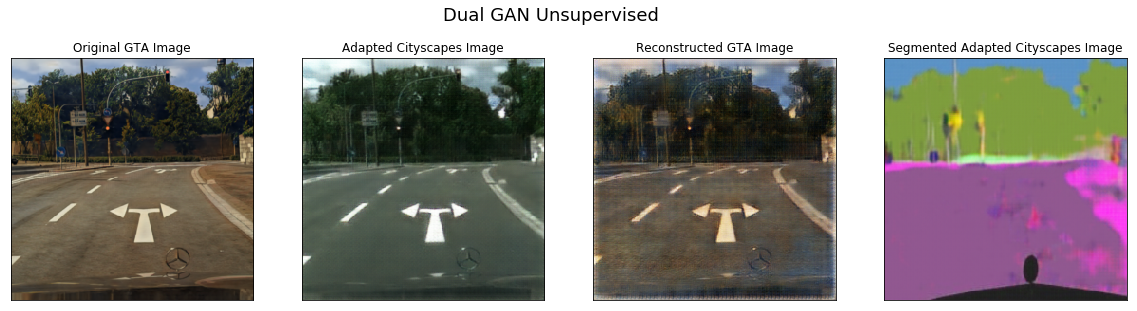

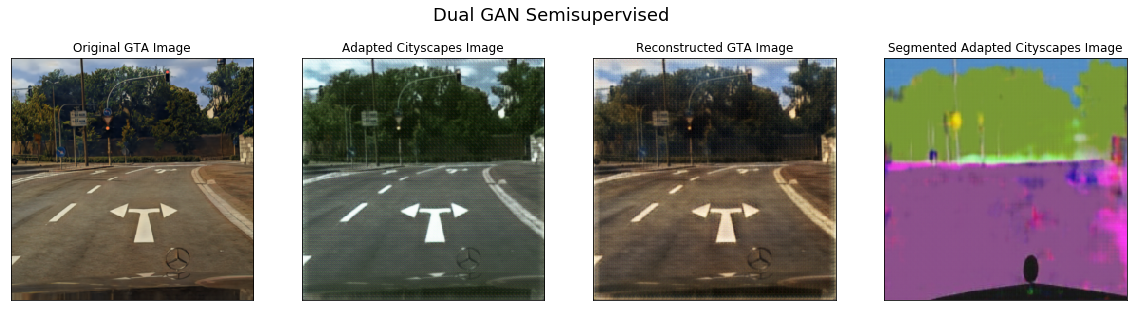

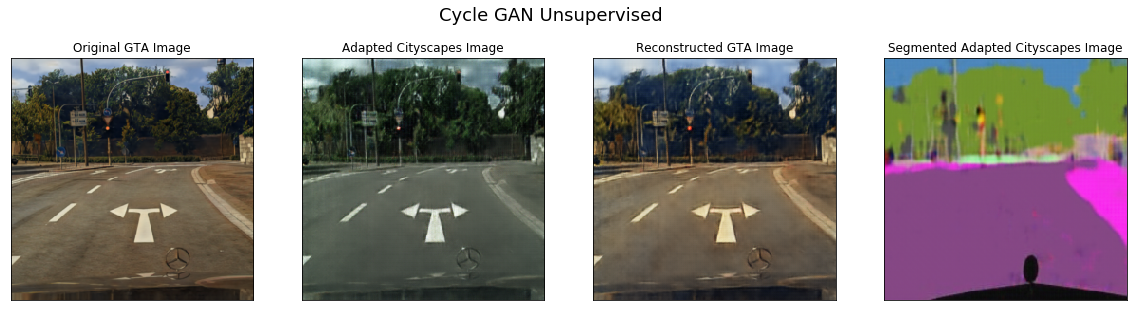

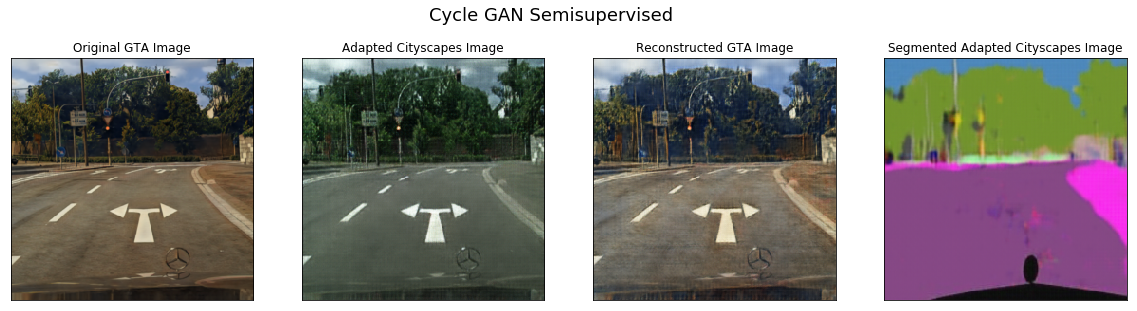

In [8]:
test_model()

### Generate Result Images

In [9]:
def sample_images():
    batch_size = 4
    data = DataLoader(data_root, image_size, batch_size)
    
    pos = int(np.random.rand() * len(data.names)/batch_size)
    if pos < 0 or (pos+1) * batch_size >= len(data.names) * batch_size: 
        pos = 0
        
    x, y = next(data.data_generator(pos))

    gta = Variable(y, requires_grad = False).to(device)
    gta_im = normalize(gta)
    
    dual_gan_un = dual_gans_unsupervised(gta_im)
    dual_gan_semi = dual_gans_semisupervised(gta_im)
    cycle_gan_un = cycle_gan_unsupervised(gta_im)
    cycle_gan_semi = cycle_gan_semisupervised(gta_im)
    
    output = torch.cat((gta.data, dual_gan_un.data, dual_gan_semi.data, cycle_gan_un.data, cycle_gan_semi.data), -2)
    save_image(output, "saved_images/all_models.png", normalize=True)

In [10]:
sample_images()